# Generic sklearn model - MIA (RandomForest)

Download data from https://physionet.org/content/mimic2-iaccd/1.0/ (https://physionet.org/content/mimic2-iaccd/1.0/full_cohort_data.csv to download the full_cohort data)

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix#, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from metricPlots import *
from MIA import *

%matplotlib inline

# Load data

In [2]:
path = "../../data/mimic2-iaccd/1.0/"
data_path = os.path.join(path, 'full_cohort_data.csv')

In [3]:
X = pd.read_csv(data_path)

# Exploring and processing data

In [4]:
X.head()

,aline_flg,icu_los_day,hospital_los_day,age,gender_num,weight_first,bmi,sapsi_first,sofa_first,service_unit,...,platelet_first,sodium_first,potassium_first,tco2_first,chloride_first,bun_first,creatinine_first,po2_first,pco2_first,iv_day_1
0,1,7.63,13,72.36841,1.0,75.0,29.912791,15.0,9.0,SICU,...,354.0,138.0,4.6,15.0,109.0,41.0,1.6,196.0,39.0,2230.875000
1,0,1.14,1,64.92076,0.0,55.0,20.121312,NaN,5.0,MICU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.000000
2,0,2.86,5,36.50000,0.0,70.0,27.118272,16.0,5.0,MICU,...,295.0,144.0,3.9,17.0,101.0,16.0,0.8,298.0,30.0,2086.800293
3,1,0.58,3,44.49191,0.0,NaN,NaN,21.0,7.0,SICU,...,262.0,139.0,4.2,31.0,100.0,16.0,0.5,146.0,23.0,NaN
4,1,1.75,5,23.74217,1.0,95.2,28.464563,18.0,7.0,SICU,...,22.0,146.0,3.4,19.0,110.0,10.0,1.0,134.0,30.0,2358.244141


## Data specific processing

For data from https://physionet.org/content/mimic2-iaccd/1.0/

In [5]:
#remove columns non-numerical and repetitive or uninformative data for the analysis
col = ['service_unit', 'day_icu_intime', 'hosp_exp_flg','icu_exp_flg', 'day_28_flg'] 
#service_num is the numerical version of service_unit
#day_icu_intime_num is the numerical version of day_icu_intime
# the other columns are to do with death and are somewhat repetitive with censor_flg
X = X.drop(col,axis = 1)
#drop columns with only 1 value
X.drop('sepsis_flg', axis=1, inplace=True)

Generic cleaning up (all data sets)

In [6]:
#drop NA by row
X.dropna(axis=0, inplace=True)
X.shape

(1064, 40)


# Define variable of interest

In [7]:
#Change it for each dataset
var = 'censor_flg'#'aline_flg'#

Obtain labels and remove them from the data

In [8]:
y = X[var]
# Drop the column that contains the labels
X.drop([var], axis=1, inplace=True)

In [9]:
y = np.array(y)
X = np.array(X)
X.shape

(1064, 39)

# Define and train the target Models


In [10]:
test_size = 0.2 #Define test size
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=test_size, random_state=58954)

In [11]:
classifiers = {
        'RandomForest':RandomForestClassifier(bootstrap=False), # Added by SR to make sure MIA was working -- this hyp param makes it very MIA susceptible
        'DecisionTree':DecisionTreeClassifier(),
        'GaussianProcess':GaussianProcessClassifier(),
        'MLP':MLPClassifier(),
        'KN':KNeighborsClassifier(),
        'SVM':SVC(kernel='rbf', probability=True)
}

In [13]:
trained_models = {}
for name,model in classifiers.items():
    trained_models[name] = model.fit(X_train, y_train) # Fixed: this had X, y instead of train data

Model RandomForest
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        59
           1       0.99      1.00      1.00       154

    accuracy                           1.00       213
   macro avg       1.00      0.99      0.99       213
weighted avg       1.00      1.00      1.00       213

Confusion matrix, without normalization


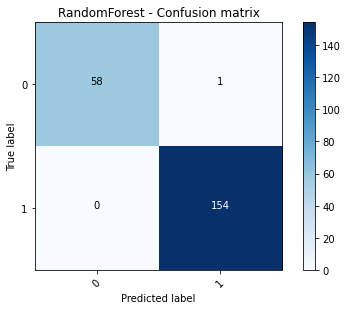

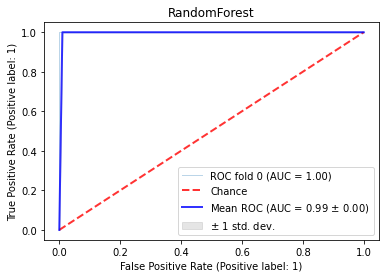

Model DecisionTree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00       154

    accuracy                           1.00       213
   macro avg       1.00      1.00      1.00       213
weighted avg       1.00      1.00      1.00       213

Confusion matrix, without normalization


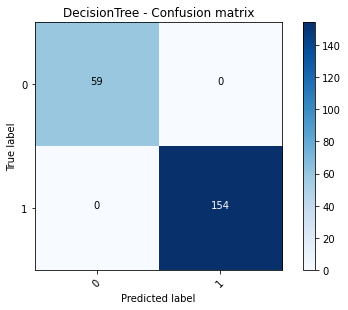

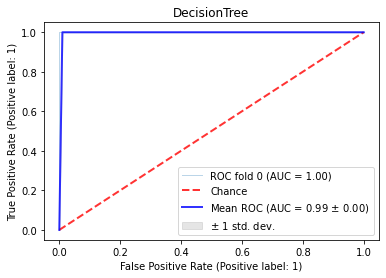

Model GaussianProcess
              precision    recall  f1-score   support

           0       0.28      1.00      0.44        59
           1       1.00      0.01      0.01       154

    accuracy                           0.28       213
   macro avg       0.64      0.50      0.22       213
weighted avg       0.80      0.28      0.13       213

Confusion matrix, without normalization


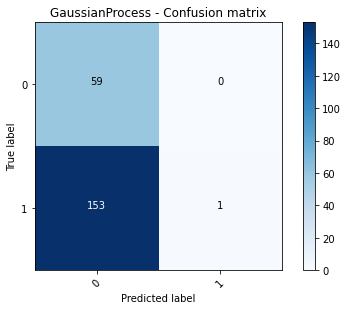

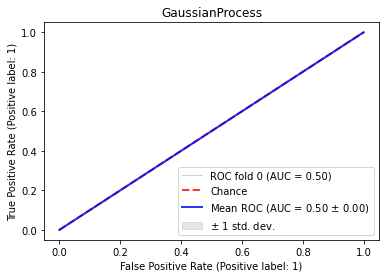

Model MLP
              precision    recall  f1-score   support

           0       0.97      0.95      0.96        59
           1       0.98      0.99      0.98       154

    accuracy                           0.98       213
   macro avg       0.97      0.97      0.97       213
weighted avg       0.98      0.98      0.98       213

Confusion matrix, without normalization


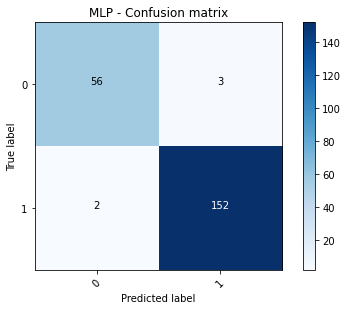

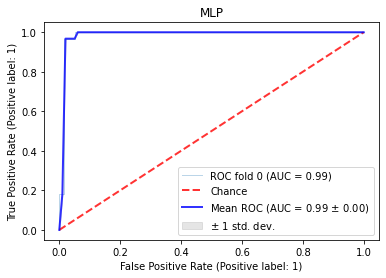

Model KN
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        59
           1       0.98      1.00      0.99       154

    accuracy                           0.99       213
   macro avg       0.99      0.97      0.98       213
weighted avg       0.99      0.99      0.99       213

Confusion matrix, without normalization


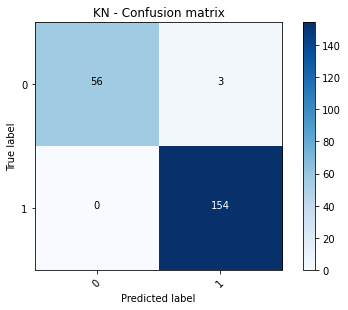

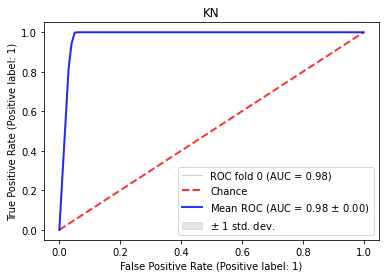

Model SVM
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        59
           1       0.98      1.00      0.99       154

    accuracy                           0.99       213
   macro avg       0.99      0.97      0.98       213
weighted avg       0.99      0.99      0.99       213

Confusion matrix, without normalization


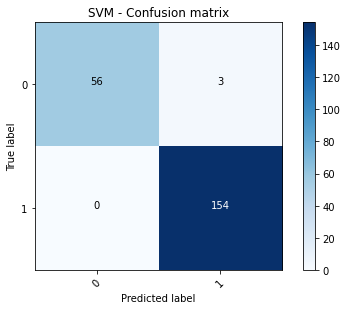

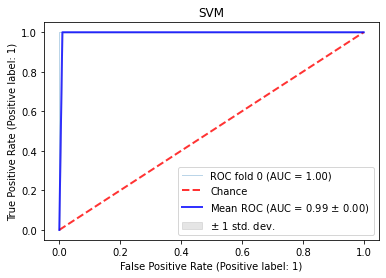

In [14]:
for name, model in trained_models.items():
    print('Model', name)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    plot_confusion_matrix(name, confusion_matrix(y_test, y_pred), 2)#range(2))
    plotROC_classifier(model, X_test, y_test, name)# deleted arguments X,y as not necessary

# Memebership inference attack

This attack makes the assumption that the attacker has access to the actual training and test data. It is not a realistic attack model _but_ demonstrates whether or not the model is _intrinsically_ problematic.

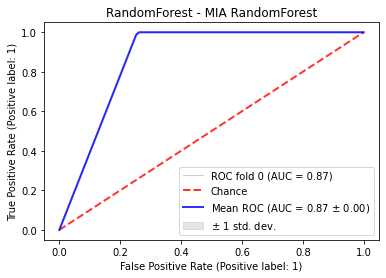

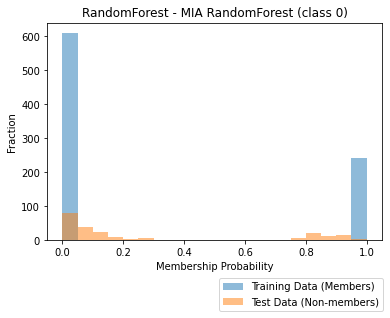

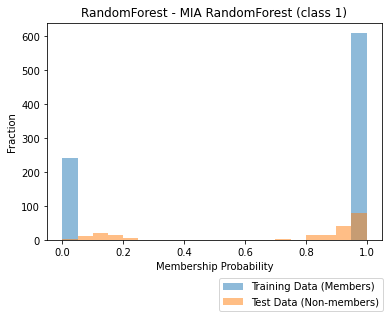

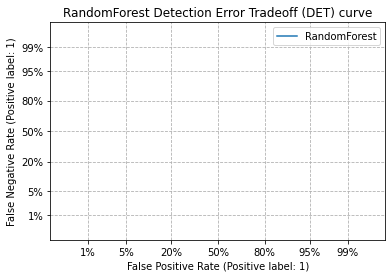

Attacker advantage 0.7441860465116279


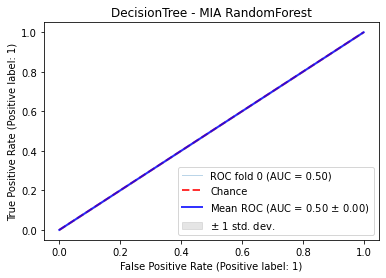

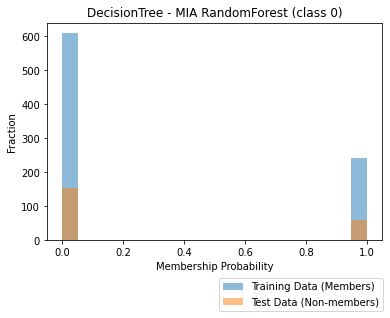

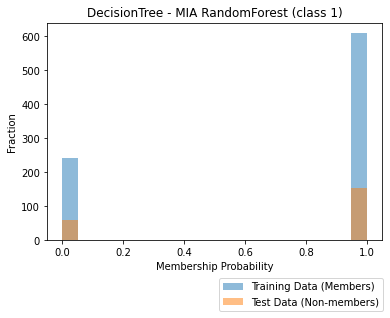

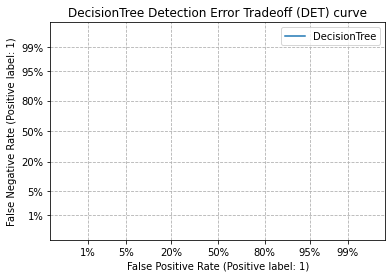

Attacker advantage 0.0


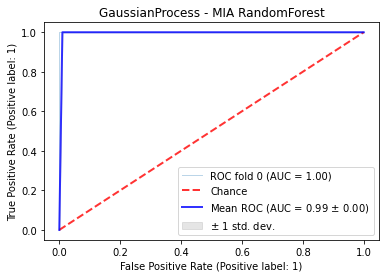

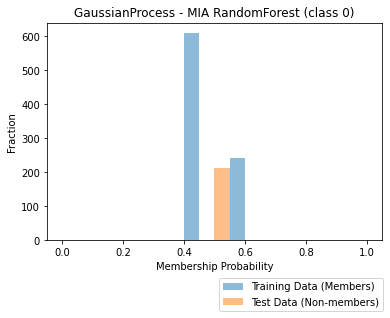

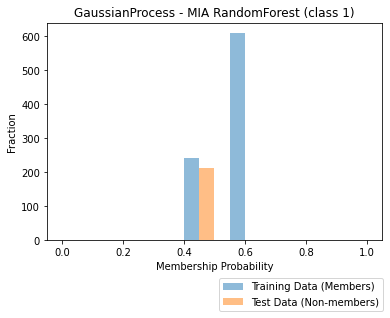

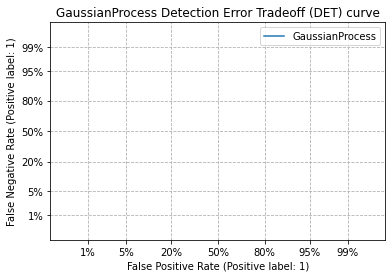

Attacker advantage 1.0


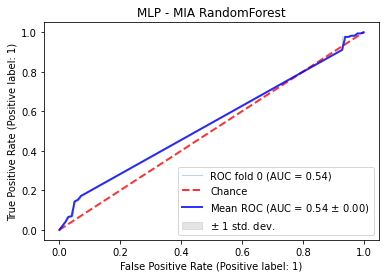

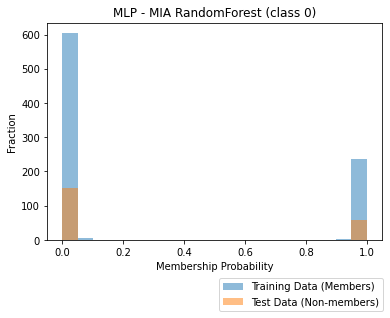

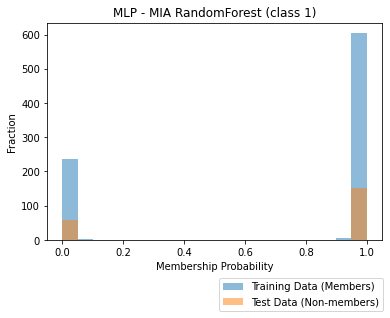

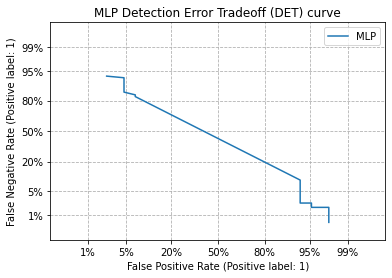

Attacker advantage 0.022982216142270806


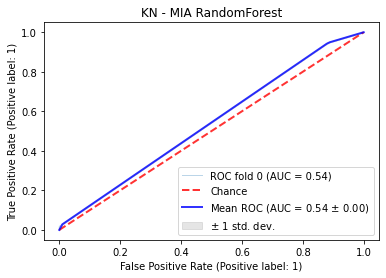

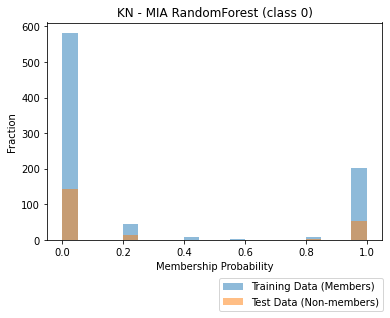

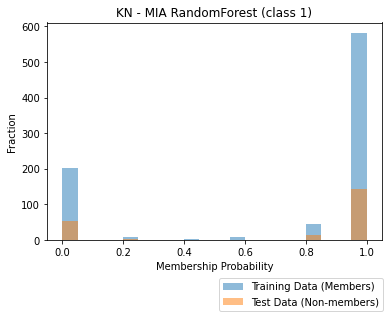

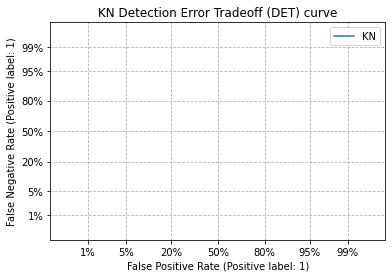

Attacker advantage 0.0


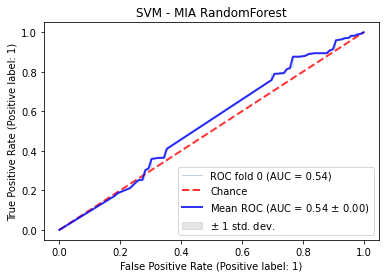

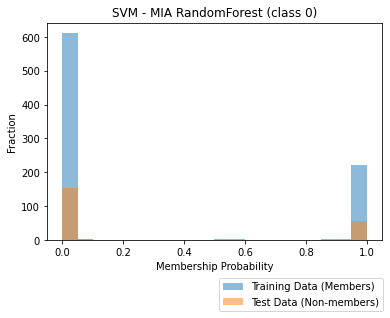

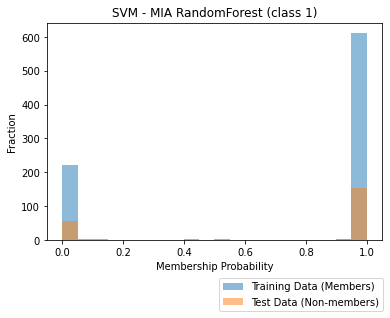

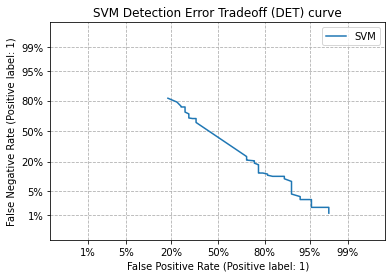

Attacker advantage 0.073734610123119


In [28]:
for name, model in trained_models.items():
    mia_name = 'RandomForest'
    run_membership_inference_attack(name, model, X_train, X_test, RandomForestClassifier(), 'RandomForest')